In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
import keras

Using TensorFlow backend.


# Embedding example

## Listing 6.6

In [3]:
from keras.datasets import imdb
from keras import preprocessing

max_features = 10000
max_len = 20
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
x_train = preprocessing.sequence.pad_sequences(x_train, maxlen=max_len)
x_test = preprocessing.sequence.pad_sequences(x_test, maxlen=max_len)

## Listing 6.7

In [4]:
from keras.layers import Flatten, Dense
from keras.layers.embeddings import Embedding
from keras.models import Sequential

model = Sequential()
model.add(Embedding(10000, 8, input_length=max_len))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
model.summary()
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_split=0.2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 20, 8)             80000     
_________________________________________________________________
flatten_1 (Flatten)          (None, 160)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 161       
Total params: 80,161
Trainable params: 80,161
Non-trainable params: 0
_________________________________________________________________
Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 1s - loss: 0.6560 - acc: 0.6483 - val_loss: 0.5907 - val_acc: 0.7146
Epoch 2/10
20000/20000 [==============================] - 1s - loss: 0.5189 - acc: 0.7593 - val_loss: 0.5117 - val_acc: 0.7364
Epoch 3/10
20000/20000 [==============================] - 1s - loss: 0.4512 - acc: 0.7933 - val_los

## Listing 6.8

In [5]:
import os

imdb_dir = 'data/aclImdb'
train_dir = os.path.join(imdb_dir, 'train')

texts = []
labels = []
data = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(train_dir, label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname))
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

## Listing 6.9

In [6]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np
maxlen = 100  # We will cut reviews after 100 words
training_samples = 200  # We will be training on 200 samples
validation_samples = 10000  # We will be validating on 10000 samples
max_words = 10000  # We will only consider the top 10,000 words in the dataset
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
data = pad_sequences(sequences, maxlen=maxlen)
labels = np.asarray(labels)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)
# Split the data into a training set and a validation set
# But first, shuffle the data, since we started from data
# where sample are ordered (all negative first, then all positive).
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]

Found 88582 unique tokens.
Shape of data tensor: (25000, 100)
Shape of label tensor: (25000,)


## Listing 6.10

In [8]:
glove_dir = 'data/glove.6B'
embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


## Listing 6.11

In [9]:
embedding_dim = 100
embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if i < max_words:
        if embedding_vector is not None:
            # Words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector

## Listing 6.12

In [10]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_2 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


## Listing 6.13

In [11]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

## Listing 6.14

In [12]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val))
model.save_weights('data/pre_trained_glove_model.hy')

Train on 200 samples, validate on 10000 samples
Epoch 1/10
200/200 [==============================] - 0s - loss: 2.0330 - acc: 0.5150 - val_loss: 0.7080 - val_acc: 0.5280
Epoch 2/10
200/200 [==============================] - 0s - loss: 0.5200 - acc: 0.7500 - val_loss: 0.9982 - val_acc: 0.5016
Epoch 3/10
200/200 [==============================] - 0s - loss: 0.4036 - acc: 0.8550 - val_loss: 0.7131 - val_acc: 0.5468
Epoch 4/10
200/200 [==============================] - 0s - loss: 0.3286 - acc: 0.8650 - val_loss: 1.0479 - val_acc: 0.5001
Epoch 5/10
200/200 [==============================] - 0s - loss: 0.2386 - acc: 0.9400 - val_loss: 0.7077 - val_acc: 0.5712
Epoch 6/10
200/200 [==============================] - 0s - loss: 0.1130 - acc: 0.9950 - val_loss: 0.8121 - val_acc: 0.5426
Epoch 7/10
200/200 [==============================] - 0s - loss: 0.3223 - acc: 0.8450 - val_loss: 0.8190 - val_acc: 0.5380
Epoch 8/10
200/200 [==============================] - 0s - loss: 0.0614 - acc: 1.0000 - val

## Listing 6.15

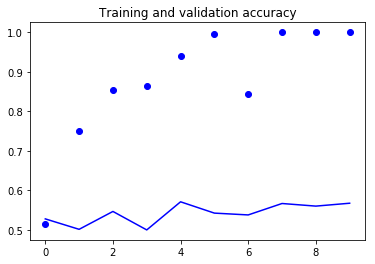

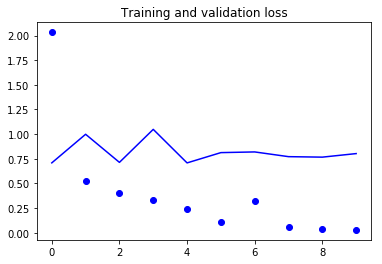

In [13]:
import matplotlib.pyplot as plt


acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'bo')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation accuracy')
plt.figure()
plt.plot(epochs, loss, 'bo')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.show()

## Listing 6.16

In [14]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_3 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________
Train on 200 samples, validate on 10000 samples
Epoch 1/10
200/200 [==============================] - 1s - loss: 0.6898 - acc: 0.4750 - val_loss: 0.6926 - val_acc: 0.5268
Epoch 2/10
200/200 [==============================] - 0s - loss: 0.4995 - acc: 0.9850 - val_l

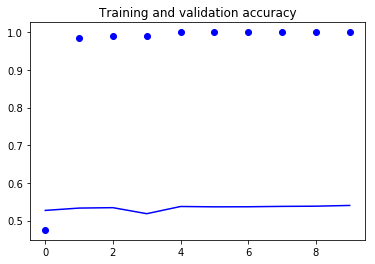

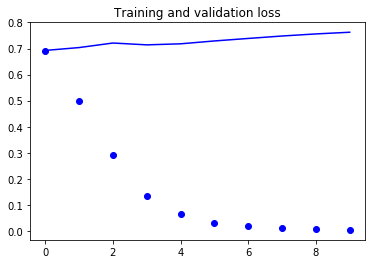

In [15]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'bo')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation accuracy')
plt.figure()
plt.plot(epochs, loss, 'bo')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.show()

## Listing 6.17

In [16]:
test_dir = os.path.join(imdb_dir, 'test')
labels = []
texts = []
for label_type in ['neg', 'pos']:
    dir_name = os.path.join(test_dir, label_type)
    for fname in sorted(os.listdir(dir_name)):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname))
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)
sequences = tokenizer.texts_to_sequences(texts)
x_test = pad_sequences(sequences, maxlen=maxlen)
y_test = np.asarray(labels)

In [18]:
model.load_weights('data/pre_trained_glove_model.hy')
model.evaluate(x_test, y_test)

24736/25000 [============================>.] - ETA: 0s

[0.8065456716823578, 0.55488000000000004]

# RNN example

## return only the last state

In [20]:
from keras.layers import Embedding, SimpleRNN
from keras.models import Sequential
model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 32)                2080      
Total params: 322,080
Trainable params: 322,080
Non-trainable params: 0
_________________________________________________________________


## return the full state sequence

In [21]:
model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32, return_sequences=True))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, None, 32)          2080      
Total params: 322,080
Trainable params: 322,080
Non-trainable params: 0
_________________________________________________________________


In [22]:
model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_4 (SimpleRNN)     (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_5 (SimpleRNN)     (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_6 (SimpleRNN)     (None, 32)                2080      
Total params: 328,320
Trainable params: 328,320
Non-trainable params: 0
_________________________________________________________________


### Listing 6.26 - 6.28

In [25]:
from keras.datasets import imdb
from keras.preprocessing import sequence
max_features = 10000  # number of words to consider as features
maxlen = 500  # cut texts after this number of words (among top max_features most common words)
batch_size = 32
print('Loading data...')
(input_train, y_train), (input_test, y_test) = imdb.load_data(num_words=max_features)
print(len(input_train), 'train sequences')
print(len(input_test), 'test sequences')
print('Pad sequences (samples x time)')
input_train = sequence.pad_sequences(input_train, maxlen=maxlen)
input_test = sequence.pad_sequences(input_test, maxlen=maxlen)
print('input_train shape:', input_train.shape)
print('input_test shape:', input_test.shape)

Loading data...
25000 train sequences
25000 test sequences
Pad sequences (samples x time)
input_train shape: (25000, 500)
input_test shape: (25000, 500)


In [26]:
from keras.layers import Dense

model = Sequential()
model.add(Embedding(max_features, 32))
model.add(SimpleRNN(32))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(input_train, y_train, epochs=10, batch_size=128, validation_split=0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 56s - loss: 0.6728 - acc: 0.5778 - val_loss: 0.5841 - val_acc: 0.7838
Epoch 2/10
20000/20000 [==============================] - 53s - loss: 0.4377 - acc: 0.8279 - val_loss: 0.4369 - val_acc: 0.8050
Epoch 3/10
20000/20000 [==============================] - 51s - loss: 0.2788 - acc: 0.8883 - val_loss: 0.5756 - val_acc: 0.7522
Epoch 4/10
20000/20000 [==============================] - 51s - loss: 0.1856 - acc: 0.9297 - val_loss: 0.4343 - val_acc: 0.8166
Epoch 5/10
20000/20000 [==============================] - 50s - loss: 0.1178 - acc: 0.9583 - val_loss: 0.5460 - val_acc: 0.7838
Epoch 6/10
20000/20000 [==============================] - 52s - loss: 0.0748 - acc: 0.9761 - val_loss: 0.5136 - val_acc: 0.8194
Epoch 7/10
20000/20000 [==============================] - 50s - loss: 0.0474 - acc: 0.9861 - val_loss: 0.5202 - val_acc: 0.8460
Epoch 8/10
20000/20000 [==============================]

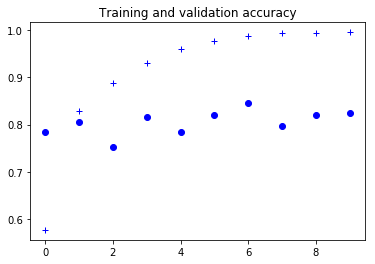

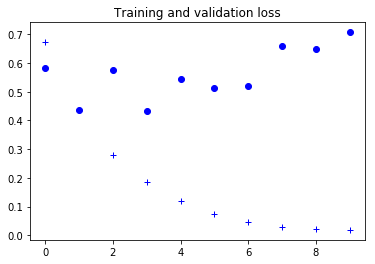

In [27]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b+')
plt.plot(epochs, val_acc, 'bo')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'b+')
plt.plot(epochs, val_loss, 'bo')
plt.title('Training and validation loss')

plt.show()

## Listing 6.31

In [29]:
from keras.layers.recurrent import LSTM

model = Sequential()
model.add(Embedding(max_features, 32))
model.add(LSTM(32))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(input_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 258s - loss: 0.5081 - acc: 0.7566 - val_loss: 0.3719 - val_acc: 0.8496
Epoch 2/10
20000/20000 [==============================] - 259s - loss: 0.2985 - acc: 0.8860 - val_loss: 0.3199 - val_acc: 0.8628
Epoch 3/10
20000/20000 [==============================] - 264s - loss: 0.2323 - acc: 0.9115 - val_loss: 0.3092 - val_acc: 0.8898
Epoch 4/10
20000/20000 [==============================] - 261s - loss: 0.2009 - acc: 0.9268 - val_loss: 0.3220 - val_acc: 0.8824
Epoch 5/10
20000/20000 [==============================] - 268s - loss: 0.1729 - acc: 0.9371 - val_loss: 0.3645 - val_acc: 0.8804
Epoch 6/10
20000/20000 [==============================] - 265s - loss: 0.1601 - acc: 0.9431 - val_loss: 0.2982 - val_acc: 0.8932
Epoch 7/10
20000/20000 [==============================] - 259s - loss: 0.1401 - acc: 0.9502 - val_loss: 0.4737 - val_acc: 0.8280
Epoch 8/10
20000/20000 [========================

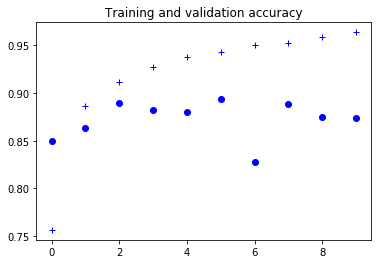

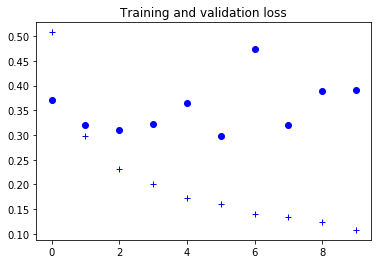

In [30]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b+')
plt.plot(epochs, val_acc, 'bo')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'b+')
plt.plot(epochs, val_loss, 'bo')
plt.title('Training and validation loss')

plt.show()